# **Caso de estudio 6.** Modelo Linear Mixto

## 1. Base de datos: Salaries Municipality Guayaquil

Link: https://www.kaggle.com/datasets/danielveraec/salaries-municipality-guayaquil?resource=download

Este dataset contiene información sobre la remuneración de los colaboradores del municipio de Guayaquil. Incluye datos como el nombre del colaborador, su cargo institucional, régimen laboral, ítem presupuestario, grado jerárquico, remuneración mensual y anual, remuneración por décimo tercer y décimo cuarto sueldo, horas suplementarias, cargos y subrogaciones, ingresos adicionales totales, mes y año en que se generaron los ingresos y el municipio al que pertenece el colaborador. Este dataset puede ser útil para analizar la remuneración de los empleados públicos en Guayaquil y cómo ésta varía según diferentes factores.


Variables clave :
- names: Nombre del empleado
- institutional_position: Cargo dentro del municipio
- hierarchical_grade: Nivel jerárquico del cargo
- monthly_remuneration: Salario mensual
- annual_remuneration: Salario anual
- labor_regime: Tipo de contrato (LOSEP, CT, etc.)
- budget_item: Código presupuestario
- municipality: Municipio (solo Guayaquil)
- year y month: Año y mes de la información

## 2. Definiendo la estructura jerárquica

Podemos considerar la siguiente jerarquía:
- Nivel 1 (Grupo Superior): Posición institucional (institutional_position)
- Nivel 2 (Grupo Secundario): Empleados individuales (names)

Esto nos permitirá modelar el salario mensual (monthly_remuneration) como una variable dependiente, incorporando efectos aleatorios por cargo.

## 3. Planteamiento del problema de negocio

📌 **Pregunta de negocio:**  
"¿Cómo varía la remuneración mensual entre diferentes cargos del municipio, considerando variaciones individuales de los empleados?"


📌 **Objetivo del modelo:**  
Identificar la influencia del cargo sobre la remuneración mensual.  
Capturar variabilidad dentro de cada cargo (efecto aleatorio).  
Diferenciar los efectos fijos (por régimen laboral, jerarquía, etc.).


## 4. Código para el Modelo Linear Mixto.

In [6]:
#pip install pymer4


In [7]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pymer4.models import Lmer


In [8]:
# 📌 1. Cargar los datos
file_path = "salaries-municipality-guayaquil.xlsx"
df = pd.read_excel(file_path, sheet_name = "salaries")


In [9]:
# 📌 2. Seleccionar las columnas de interés
df_clean = df[['institutional_position', 'hierarchical_grade', 'labor_regime', 'monthly_remuneration']]
df_clean.head()


,institutional_position,hierarchical_grade,labor_regime,monthly_remuneration
0,TESORERO,19B,LOSEP,4751.74
1,FAENADOR,2-,CT,515.64
2,ASISTENTE ADMINISTRATIVO,10-,LOSEP,756.00
3,ASISTENTE DE RESOLUCIONES,9-,LOSEP,714.00
4,FISCALIZADOR/CONTROL URBANIZ Y USOS/SUEL,11-,LOSEP,873.80


In [10]:
# Mostrar el conteo de valores nulos 
print("Valores nulos antes de la limpieza:")
df_clean.isnull().sum()


Valores nulos antes de la limpieza:


institutional_position    0
hierarchical_grade        0
labor_regime              2
monthly_remuneration      0
dtype: int64

In [11]:
# Eliminar filas con valores nulos
df_clean = df_clean.dropna()
print("Las dimensiones del dataset es: ", df_clean.shape)
print("\nLas primeras filas del dataset es: ")
df_clean.head()


Las dimensiones del dataset es:  (93538, 4)

Las primeras filas del dataset es: 


,institutional_position,hierarchical_grade,labor_regime,monthly_remuneration
0,TESORERO,19B,LOSEP,4751.74
1,FAENADOR,2-,CT,515.64
2,ASISTENTE ADMINISTRATIVO,10-,LOSEP,756.00
3,ASISTENTE DE RESOLUCIONES,9-,LOSEP,714.00
4,FISCALIZADOR/CONTROL URBANIZ Y USOS/SUEL,11-,LOSEP,873.80


In [12]:
# Renombrar columnas para facilitar el uso en fórmulas
df_clean = df_clean.rename(columns = {"institutional_position": "position",
                                      "hierarchical_grade": "grade",
                                      "labor_regime": "regime",
                                      "monthly_remuneration": "salary"
                                     })


In [13]:
# Convertir variables categóricas en formato adecuado
df_clean["position"] = df_clean["position"].astype(str)
df_clean["grade"] = df_clean["grade"].astype(str)
df_clean["regime"] = df_clean["regime"].astype(str)


In [14]:
# 📌 3. Definir el modelo lineal mixto en pymer4
modelo_base = Lmer("salary ~ grade + regime + (1 | position)", data=df_clean)

modelo = Lmer("salary ~ grade + regime + (1 + grade | position)", data = df_clean)


In [15]:
# Ajustar el modelo con verificación
try:
    resultado_base = modelo_base.fit()
    print("✅ Modelo ajustado correctamente")
except Exception as e:
    print(f"❌ Error al ajustar el modelo: {e}")
    exit()


Linear mixed model fit by REML [’lmerMod’]
Formula: salary~grade+regime+(1|position)

Family: gaussian	 Inference: parametric

Number of observations: 93538	 Groups: {'position': 1296.0}

Log-likelihood: -499592.823 	 AIC: 999435.645

Random effects:

                 Name        Var      Std
position  (Intercept)  14598.280  120.823
Residual                2409.548   49.087

No random effect correlations specified

Fixed effects:

✅ Modelo ajustado correctamente


/opt/anaconda3/lib/python3.12/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


In [16]:
# Mostrar los resultados del modelo
resultado_base


,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),244.172,198.204,290.139,23.453,92582.145,10.411,0.000,***
grade1,254.989,190.687,319.291,32.808,92289.969,7.772,0.000,***
grade1 -,379.236,333.776,424.696,23.194,92401.864,16.351,0.000,***
grade1 J,-365.532,-414.904,-316.159,25.191,92694.950,-14.511,0.000,***
grade1-,260.243,200.872,319.613,30.292,92327.344,8.591,0.000,***
...,...,...,...,...,...,...,...,...
regime3,696.981,669.132,724.831,14.209,38004.182,49.051,0.000,***
regime4,-63.327,-70.156,-56.497,3.485,92265.112,-18.174,0.000,***
regimeCT,51.052,12.647,89.457,19.595,92361.805,2.605,0.009,**
regimeLOEI,846.591,798.965,894.216,24.299,83014.417,34.840,0.000,***


**Interpretar los coeficientes:**  

Cada fila del archivo representa un coeficiente del modelo. Para interpretar los coeficientes:
- Estimate: Representa el efecto de la variable en la variable objetivo (salary).
- P-val: Si es menor a 0.05, el coeficiente es significativo.
- 2.5_ci y 97.5_ci: Intervalo de confianza del coeficiente.


Para ver qué coeficientes son estadísticamente significativos:

In [18]:
df_significativos = resultado_base[resultado_base["P-val"] < 0.05]
df_significativos


,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),244.172,198.204,290.139,23.453,92582.145,10.411,0.000,***
grade1,254.989,190.687,319.291,32.808,92289.969,7.772,0.000,***
grade1 -,379.236,333.776,424.696,23.194,92401.864,16.351,0.000,***
grade1 J,-365.532,-414.904,-316.159,25.191,92694.950,-14.511,0.000,***
grade1-,260.243,200.872,319.613,30.292,92327.344,8.591,0.000,***
...,...,...,...,...,...,...,...,...
regime3,696.981,669.132,724.831,14.209,38004.182,49.051,0.000,***
regime4,-63.327,-70.156,-56.497,3.485,92265.112,-18.174,0.000,***
regimeCT,51.052,12.647,89.457,19.595,92361.805,2.605,0.009,**
regimeLOEI,846.591,798.965,894.216,24.299,83014.417,34.840,0.000,***


**Visualizar el impacto de las variables**  
Si quieres graficar los coeficientes fijos y su intervalo de confianza:

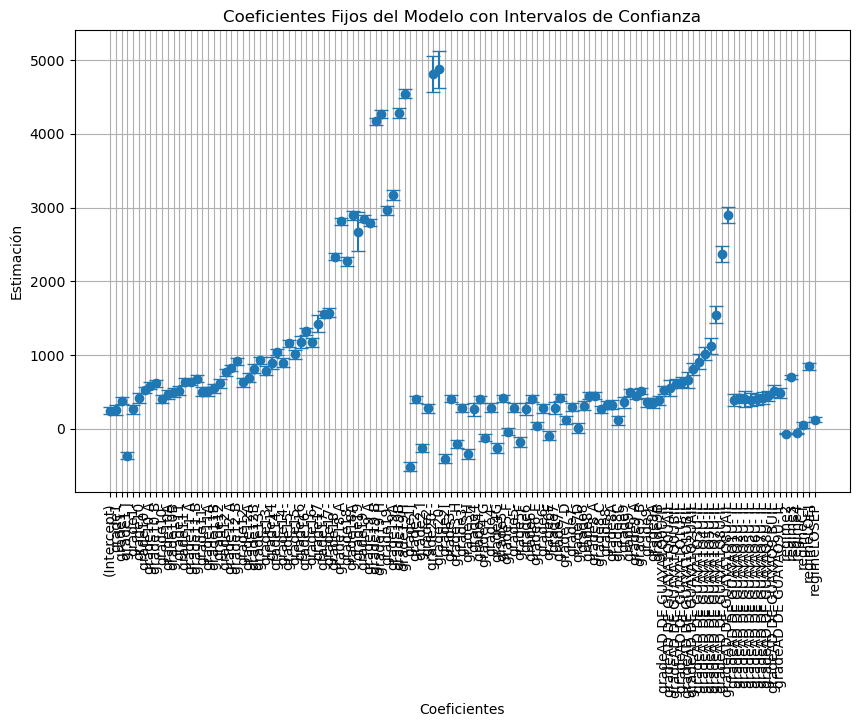

In [20]:
plt.figure(figsize=(10, 6))
plt.errorbar(resultado_base.index, resultado_base["Estimate"], 
             yerr=[resultado_base["Estimate"] - resultado_base["2.5_ci"], 
                   resultado_base["97.5_ci"] - resultado_base["Estimate"]],
             fmt = 'o', capsize = 5)

plt.xlabel("Coeficientes")
plt.ylabel("Estimación")
plt.title("Coeficientes Fijos del Modelo con Intervalos de Confianza")
plt.xticks(rotation = 90)
plt.grid()
plt.show()


## Resumen del Modelo

El modelo tiene la siguiente estructura:

$ salary = 𝛽_0 + 𝛽_1(grade) + 𝛽_2(regime) + 𝑢_{position} + 𝜖 $


Donde:
- Intercepto (β₀): Representa el salario base promedio sin considerar efectos fijos.
- Efectos fijos (β₁, β₂): Capturan la influencia de grade (nivel jerárquico) y regime (tipo de contrato).
- Efectos aleatorios (u_{\text{position}}): Capturan la variabilidad del salario entre diferentes posiciones.
- Residual (ε): Variabilidad no explicada.



## 🔍 Interpretación de Resultados

### 📊 **Resumen de efectos aleatorios**

**Random Effects (Efectos Aleatorios por Posición)**
- Var(position Intercept) = 14,598.280:
   - Indica que la variabilidad del salario entre posiciones institucionales es alta.
   - Un alto valor significa que las posiciones influyen significativamente en la remuneración.

- Residual variance = 2,409.548:
   - Representa la variabilidad del salario dentro de cada posición.
   - Comparado con la varianza del intercepto, muestra que la mayor parte de la variabilidad proviene de la posición.


📌 **Conclusión:**
- La variabilidad del salario entre posiciones (14,598.280) es mucho mayor que la variabilidad dentro de una misma posición (2,409.548).
- Esto indica que el cargo en el municipio es un fuerte determinante del salario.

## 📊 Efectos fijos

**Intercepto (β₀ = 244.172)**
- Interpretación:
   - El salario promedio base (sin efectos de grade ni regime) es 244.17.
   - Es el punto de referencia cuando todas las demás variables son cero.


**Grade (Nivel Jerárquico)**
- Diferentes niveles (grade1, grade-, grade1 J, etc.) tienen coeficientes positivos o negativos.
- Ejemplo: grade1 tiene un coeficiente de 254.989:
   - Significa que las personas en este nivel ganan en promedio 254.98 unidades más que el nivel de referencia.
- Valores negativos (grade1 J = -365.532):
   - Indican niveles donde el salario es más bajo en comparación con la referencia.


📌 **Conclusión:**
- Algunos niveles jerárquicos aumentan el salario, mientras que otros lo reducen.
- La interpretación exacta depende del nivel de referencia (que no se muestra explícitamente en la tabla).

## Regime (Tipo de contrato)

- Diferentes tipos de contratos (regime3, regimeCT, regimeLOSEP, etc.).
- Ejemplo: regimeLOEI tiene un coeficiente de 846.591:
   - Significa que los empleados con este régimen ganan 846.59 más en promedio comparado con el régimen de referencia.
regimeCT = 51.052:
- El impacto del régimen CT en el salario es menor que en otros regímenes.

📌 **Conclusión:**
- El régimen contractual tiene un impacto fuerte en los salarios.
- Algunos regímenes aumentan el salario significativamente más que otros.

## 📌 ¿Cómo interpretar el modelo para el negocio?

- El cargo institucional (position) explica una gran parte de la variabilidad salarial.
- El nivel jerárquico (grade) también tiene un impacto significativo, aunque varía dependiendo del nivel.
- El tipo de contrato (regime) es un factor determinante en el salario, con algunos regímenes pagando más que otros.
  

In [26]:
# 📌 4. Crear la carpeta de salida si no existe
output_folder = "output_data"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"📂 Carpeta creada: {output_folder}")


In [27]:
# 📌 5. Exportar efectos aleatorios (impacto de cada posición en el salario)
if "ranef_dict" in resultado_base.__dict__:
    random_effects = resultado_base.ranef
    print("✅ Se encontraron efectos aleatorios en el modelo")
    
    # Extraer los efectos aleatorios del intercepto
    random_effects_intercept = random_effects["(Intercept)"]
    
    # Crear un DataFrame con los efectos aleatorios
    df_random_effects = pd.DataFrame({
        "position": random_effects_intercept.index,
        "effect": random_effects_intercept.values
    })
    
    # Exportar efectos aleatorios a CSV
    effects_file = os.path.join(output_folder, "effects_random_position.csv")
    df_random_effects.to_csv(effects_file, index = False)
    print(f"✅ Efectos aleatorios exportados a {effects_file}")


In [28]:
# 📌 6. Exportar coeficientes fijos del modelo (impacto de grade y regime)
resultado_base.to_csv(os.path.join(output_folder, "Resultado_Modelo.csv"), index = False)
print(f"✅ Coeficientes del modelo exportados.")


✅ Coeficientes del modelo exportados.


In [29]:
print("Columnas del modelo:", modelo_base.data.columns)
print("Columnas del DataFrame:", df_clean.columns)


Columnas del modelo: Index(['position', 'grade', 'regime', 'salary', 'residuals', 'fits'], dtype='object')
Columnas del DataFrame: Index(['position', 'grade', 'regime', 'salary'], dtype='object')


In [31]:
# 📌 7. Exportar datos originales con predicciones
df_clean["predicted_salary"] = modelo_base.predict(df_clean, skip_data_checks = True, verify_predictions = False)

original_data_file = os.path.join(output_folder, "original_data_with_predictions.csv")
df_clean.to_csv(original_data_file, index = False)
print(f"✅ Datos originales con predicciones exportados a {original_data_file}")


✅ Datos originales con predicciones exportados a output_data/original_data_with_predictions.csv
